In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df=pd.read_csv("cleaned_data_PES2201800211.csv")
print("Shape:",df.shape)
df.head()

Shape: (96, 11)


,Unnamed: 0,community,age,weight,delivery_phase,hb,ifa,bp,education,residence,result
0,0,1,21.0,42.0,1.0,9.2,1,1.375,5.0,1.0,0
1,1,1,21.0,36.0,1.0,8.8,1,1.500,5.0,1.0,0
2,2,1,21.0,36.0,1.0,9.2,1,2.125,5.0,1.0,0
3,3,1,21.0,36.0,1.0,8.0,1,1.375,5.0,1.0,0
4,4,1,24.0,33.0,1.0,9.3,1,1.571,5.0,1.0,0


In [7]:
nulls=df.isnull().sum()
nulls
#(nulls*100)/96

Unnamed: 0        0
community         0
age               0
weight            0
delivery_phase    0
hb                0
ifa               0
bp                0
education         0
residence         0
result            0
dtype: int64

In [8]:
def sigmoid(Z):
  return 1/(np.exp(-Z)+1)
def relu(Z):
  return np.maximum(0,Z)

In [10]:
def init_parameters(dims):
  parameters={}
  for l in range(1,len(dims)):
    parameters["W"+ str(l)]=np.random.randn(dims[l],dims[l-1])*np.sqrt(2/dims[l-1])
    parameters["b"+ str(l)]=np.zeros(shape=(dims[l],1))
    #limit=np.sqrt(6/(dims[l]+dims[l-1]))
    # parameters["W"+ str(l)]=np.random.uniform(-limit,limit,size=(dims[l],dims[l-1]))
    # parameters["b"+ str(l)]=np.random.uniform(-limit,limit,size=(dims[l],1))
  return parameters

def forward_activation(A,W,b,activation):
  Z=W.dot(A)+b
  if activation=="relu":
    A_new=relu(Z)
  elif activation=="sigmoid":
    A_new=sigmoid(Z)
  cache=((A,W,b),Z)
  return A_new,cache

def forward_propogate(X,parameters):
  L=len(parameters)//2
  caches=[]
  A=X
  for l in range(1,L):
    A_prev=A
    A,cache=forward_activation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"sigmoid")
    caches.append(cache)
  #Last layer
  O,cache=forward_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
  caches.append(cache)
  return O,caches

In [11]:
def compute_cost(O,Y,parameters,lambd):
  assert(O.shape == Y.shape)
  m=Y.shape[1]
  #print("examples:",m)
  cost=(1./m)*(-np.dot(Y,np.log(O).T)-np.dot(1-Y,np.log(1-O).T))
  cost=np.squeeze(cost)
  assert(cost.shape==())
  L=len(parameters)//2
  reg_cost=0
  for l in range(1,L+1):
    reg_cost+=(1/m) * (lambd/2) * np.sum(parameters["W"+str(l)]**2)
  return cost   #+reg_cost

In [12]:
#Back Propogation
def relu_diff(da,z):
  dz=da.copy()
  dz[z<=0]=0
  return dz
def sigmoid_diff(da,z):
  a=sigmoid(z)
  dz=da*a*(1-a)
  return dz

def backward_activation(da,cache,activation):
  cache1,cache2=cache
  lambd=0.7
  if activation=="relu":
    dz=relu_diff(da,cache2)
  elif activation=="sigmoid":
    dz=sigmoid_diff(da,cache2)
  a_prev,W,b=cache1
  m=a_prev.shape[1]
  da_prev=np.dot(W.T,dz)
  dW=np.dot(dz,a_prev.T)*(1./m)#+(lambd/m) * W
  db=np.sum(dz,axis=1,keepdims=True)*(1./m)
  return da_prev,dW,db

def back_propogate(O,Y,caches):
  grads={}
  m=O.shape[1]
  L=len(caches)
  Y=Y.reshape(O.shape)

  dO=-(np.divide(Y,O)-np.divide(1-Y,1-O))
  current_cache=caches[L-1]
  grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=backward_activation(dO,current_cache,"sigmoid")

  for l in reversed(range(L-1)):
    current_cache=caches[l]
    grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)]=backward_activation(grads["dA"+str(l+1)],current_cache,"sigmoid")

  return grads

In [13]:
def update_parameters(parameters,v,grads,learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    beta=0.9
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v['db' + str(l+1)]
        ### END CODE HERE ###
        
    return parameters, v

In [14]:
def predict(X,Y,parameters):
  #print(X[:,[0,5,10]])
  m=X.shape[1]
  n=len(parameters)//2
  predictions=np.zeros((1,m))
  prob,cache=forward_propogate(X,parameters)
  for i in range(0,prob.shape[1]):
    if prob[0][i] > 0.5:
        predictions[0][i]=1
    else:
        predictions[0][i]=0
  #print("Accuracy: "+str(np.sum(predictions[0]==Y[0])))
  print("Accuracy: "  + str(np.sum((predictions == Y)/m)))
  return predictions

In [15]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
        ### END CODE HERE ###
        
    return v

In [16]:
def model(X,Y,layer_dims,learning_rate=0.0075,num_iterations=1500,print_cost=False):
  parameters=init_parameters(layers_dims)
  v=initialize_velocity(parameters)
  costs=[]
  for i in range(num_iterations):
    O,caches=forward_propogate(X,parameters)
    cost=compute_cost(O,Y,parameters,0.7)
    grads=back_propogate(O,Y,caches)
    parameters,v=update_parameters(parameters,v,grads,learning_rate)
    #print(O,len(O[0]))
    if print_cost and i%5000==0:
      print("Cost after",i,"iteration:",cost)
      costs.append(cost)
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('iterations per 100')
  plt.title("learning rate="+str(learning_rate))
  plt.show()

  return parameters

In [17]:
data=df.to_numpy()
X_temp=data[:,[4,5,6]]
#print(X_temp[:5,:],np.sum(X_temp,axis=0))
mean=np.sum(X_temp,axis=0)/X_temp.shape[0]
X_temp-=mean
#print(X_temp[:5,:])
X_sigma=np.sum(X_temp**2,axis=0)/X_temp.shape[0]
data[:,[4,5,6]]=X_temp/np.sqrt(X_sigma)
np.savetxt("cleaned1.csv",data,delimiter=',')
X=data[:,:-1]
Y=data[:,-1]
print(np.sum(Y==0),np.sum(Y==1))
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.30,random_state=11)
#print(X_train.T.shape,X_test.T.shape,Y_train.T.shape,Y_test.T.shape,X_train.T[:,50],Y_train.reshape((1,len(Y_train)))[0,50])

24 72


Cost after 0 iteration: 0.8274599526459258
Cost after 5000 iteration: 0.0010024175260119562
Cost after 10000 iteration: 0.00048809155046798224
Cost after 15000 iteration: 0.00032214240630018006
Cost after 20000 iteration: 0.00024028188381068212
Cost after 25000 iteration: 0.0001915452111755831
Cost after 30000 iteration: 0.00015922083803920927
Cost after 35000 iteration: 0.00013621748089491815
Cost after 40000 iteration: 0.0001190136366023087
Cost after 45000 iteration: 0.0001056627796363853
Cost after 50000 iteration: 9.500157195146844e-05
Cost after 55000 iteration: 8.629204162036707e-05
Cost after 60000 iteration: 7.904348808284116e-05
Cost after 65000 iteration: 7.291694074434475e-05
Cost after 70000 iteration: 6.767073267395916e-05
Cost after 75000 iteration: 6.312793055653655e-05


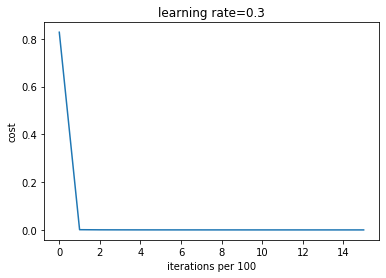

In [18]:
layers_dims=(10,10,3,1)
parameters=model(X_train.T,Y_train.reshape((1,len(Y_train))),layers_dims,learning_rate=0.3,num_iterations=80000,print_cost=True)

In [19]:
predict(X_train.T,Y_train.reshape((1,len(Y_train))),parameters)

Accuracy: 1.0


array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1.]])

In [20]:
predict(X_test.T,Y_test.reshape((1,len(Y_test))),parameters)

Accuracy: 0.9655172413793102


array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.]])

In [21]:
parameters

{'W1': array([[ 0.14397319, -0.4714069 ,  0.10569838,  1.28761188, -0.31332869,
          0.25794129, -0.04528853,  0.91316414, -0.48738832, -0.10697385],
        [ 0.55997804,  0.22820765,  0.62965227,  0.11003293,  0.38690676,
         -0.53210662, -0.13159944, -0.26098291,  0.14460105, -0.12297195],
        [ 0.40971487,  0.06905476, -0.37247552,  0.42404014, -0.78038287,
          0.58859262,  0.77804143,  0.34988948, -0.14898   ,  0.14472926],
        [-0.15705718, -0.12596583, -0.09889691, -0.06684745,  0.1624672 ,
          0.69213329,  0.12925774,  0.8825615 , -0.50069068,  0.37054265],
        [ 0.79710773, -0.43005646, -1.03175333,  0.14844545, -0.2204334 ,
         -0.13559147,  0.72338043,  0.03455969,  0.19136955,  0.25007712],
        [ 0.02032056,  0.2680566 ,  0.54591395,  0.4140202 , -0.12628519,
          0.45879875, -0.01659463, -0.82828955,  0.02552821,  0.69844353],
        [-0.66212225,  0.1408703 ,  0.92713158, -0.07499829,  0.92777182,
         -0.32240804, -1.6